In [147]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '230710_Axial_z2_Data'
dataname = data+'_Raw'+'072901'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:12]
SensorData1 = SD1

In [148]:
SD1.sample(5)

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
20968,48,42,45,45,47,45,47,18.87,118.48,14,0,3.2
34091,46,42,51,40,44,42,35,62.03,-420.29,22,0,7.2
67558,51,46,48,43,48,37,45,53.90,-2106.74,46,0,5.6
187079,44,35,47,37,40,42,49,71.80,-3752.58,130,0,8.0
177218,49,39,44,36,37,47,47,54.17,-3359.79,124,0,4.8


In [149]:
# data = '230703_Axial_z2_Data_2'
# dataname = data+'_02'
# filename = 'myData/'+data+'.csv'
# SD2 = pd.read_csv(filename)
# SD2=SD2.iloc[:,:28]
# SensorData2 = SD2
# SD2['z'] += 550
# SD2['z'] /= 5
# SD2

In [150]:
# SDreal = pd.concat([SD1, SD2])

In [151]:
SDreal = SD1

In [152]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.0,226477.000000
mean,48.346185,44.993116,48.101167,40.125554,44.090053,43.143569,47.287703,42.117940,-2505.894559,78.630024,0.0,4.797753
std,84.095088,59.711839,78.833617,66.752353,78.681733,89.272349,66.636892,24.206043,1448.535114,46.262884,0.0,2.066331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-483.760000,-5209.280000,0.000000,0.0,1.600000
25%,46.000000,43.000000,46.000000,37.000000,41.000000,40.000000,45.000000,23.220000,-3288.870000,38.000000,0.0,3.200000
50%,48.000000,45.000000,48.000000,40.000000,43.000000,42.000000,48.000000,42.420000,-2819.360000,78.000000,0.0,4.800000
75%,50.000000,47.000000,50.000000,43.000000,46.000000,45.000000,50.000000,60.550000,-1591.520000,118.000000,0.0,6.400000
max,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,103.350000,124.190000,158.000000,0.0,8.000000


In [153]:
# SDreal 값이 0보다 작은데 encoder 인 것 제거
SDreal = SDreal[~((SDreal < 0)&(SDreal.columns != "encoder")).any(axis=1)]
#SDreal = SDreal[~((SDreal['z'] % 2 == 0) & (SDreal['z'] % 4 != 0))]

# SDreal 값이 100보다 크거나 0인데, 'theta', 'z', 'Force' 열이 아닌 것 제거
SDreal = SDreal[~(((SDreal >= 100)|(SDreal == 0) ) & 
                 (SDreal.columns != "theta") &
                 (SDreal.columns != "z") &
                 (SDreal.columns != "Force") &
                  (SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 8191이거나 8190인 것 제거
SDreal = SDreal[~((SDreal == 8191) | (SDreal == 8190)).any(axis=1)]

# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[~((SDreal >= 800) & (SDreal.columns == "Force")).any(axis=1)]
SDreal = SDreal[~((SDreal <= -300) & (SDreal.columns == "Force")).any(axis=1)]

SDreal = SDreal[SDreal["r"] >= 0.8*3]
SDreal = SDreal[SDreal["z"] <= 130]
SDreal = SDreal[SDreal["z"] >= 30]
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,110999.000000,110999.000000,110999.000000,110999.000000,110999.000000,110999.000000,110999.000000,110999.000000,110999.000000,110999.000000,110999.0,110999.000000
mean,49.220939,45.585780,46.644510,39.313111,43.503329,41.547663,46.186957,56.822513,-2657.024899,79.929963,0.0,5.599993
std,2.791750,4.677129,4.486153,4.959225,4.167696,3.713219,3.749545,17.349593,613.766912,29.424596,0.0,1.600106
min,12.000000,27.000000,28.000000,20.000000,22.000000,28.000000,29.000000,22.040000,-3761.890000,30.000000,0.0,3.200000
25%,47.000000,43.000000,44.000000,36.000000,41.000000,39.000000,44.000000,42.830000,-2912.520000,54.000000,0.0,4.000000
50%,49.000000,46.000000,47.000000,40.000000,43.000000,41.000000,47.000000,57.420000,-2821.030000,80.000000,0.0,5.600000
75%,51.000000,49.000000,50.000000,43.000000,46.000000,44.000000,49.000000,71.690000,-2532.875000,106.000000,0.0,7.200000
max,62.000000,61.000000,80.000000,53.000000,60.000000,54.000000,57.000000,103.350000,-896.130000,130.000000,0.0,8.000000


In [154]:
def normalize_dataframe(df, columns):
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / (df[column].max() - df[column].min()) * 2
    return df


#SDreal_normalized = normalize_dataframe(SDreal)
SDreal_normalized = normalize_dataframe(SDreal, ['r', 'Force', 'z'])
SDreal = SDreal_normalized
SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
43824,49,44,47,44,44,48,43,-0.799963,-896.22,-0.998599,0,-0.999997
43825,49,47,47,44,44,48,43,-0.800455,-896.22,-0.998599,0,-0.999997
43826,49,47,47,44,44,49,43,-0.802915,-896.22,-0.998599,0,-0.999997
43827,49,47,47,44,44,49,43,-0.802669,-896.22,-0.998599,0,-0.999997
43828,49,47,47,44,44,49,43,-0.802915,-896.22,-0.998599,0,-0.999997
...,...,...,...,...,...,...,...,...,...,...,...,...
187148,45,35,42,36,40,45,49,0.354876,-3760.93,1.001401,0,1.000003
187149,48,35,42,37,41,45,50,0.357090,-3761.37,1.001401,0,1.000003
187150,48,35,42,37,41,45,50,0.356106,-3761.63,1.001401,0,1.000003
187151,48,35,42,38,41,45,50,0.354384,-3761.89,1.001401,0,1.000003


In [155]:
SDy = SDreal.iloc[:,[7,9]]
SDy.describe()

,Force,z
count,1.109990e+05,1.109990e+05
mean,-1.231395e-14,3.659750e-14
std,4.267518e-01,5.884919e-01
min,-8.555531e-01,-9.985993e-01
25%,-3.441769e-01,-5.185993e-01
50%,1.469653e-02,1.400733e-03
75%,3.656989e-01,5.214007e-01
max,1.144447e+00,1.001401e+00


In [156]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# SDreal.hist(bins=50, figsize=(20,15))
# plt.savefig('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/SensorCallbi/LABS_v3/savefig/'+dataname+'_hist230320.png')
# plt.show()

In [157]:
X = SDreal.iloc[:,:7]
y = SDreal.iloc[:,[7,9]]

In [158]:
X

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06
43824,49,44,47,44,44,48,43
43825,49,47,47,44,44,48,43
43826,49,47,47,44,44,49,43
43827,49,47,47,44,44,49,43
43828,49,47,47,44,44,49,43
...,...,...,...,...,...,...,...
187148,45,35,42,36,40,45,49
187149,48,35,42,37,41,45,50
187150,48,35,42,37,41,45,50
187151,48,35,42,38,41,45,50


In [159]:
y.sample(5)

,Force,z
170015,0.871172,0.761401
76518,0.231890,-0.558599
104747,0.165477,-0.158599
70657,0.172857,-0.638599
54195,0.323392,-0.878599


In [160]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [161]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  87911 ea 79 %    X_valid:  21978 ea 19 %    X_test:  1110 ea 1 %


In [162]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [163]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230710_Axial_z2_Data_Raw072901_SS.pkl']

In [164]:
from tensorflow import keras
model = keras.models.Sequential([                       
    keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(8, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(2)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                256       
                                                                 
 dense_25 (Dense)            (None, 16)                528       
                                                                 
 dense_26 (Dense)            (None, 8)                 136       
                                                                 
 dense_27 (Dense)            (None, 2)                 18        
                                                                 
Total params: 938
Trainable params: 938
Non-trainable params: 0
_________________________________________________________________


## Callback (best, early stopping, tensorboard)

In [165]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230320_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [166]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [167]:
dataname

'230710_Axial_z2_Data_Raw072901'

In [168]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 4
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
2748/2748 [==============================] - 5s 1ms/step - loss: 0.0378 - val_loss: 0.0293
Epoch 2/300
2748/2748 [==============================] - 3s 1ms/step - loss: 0.0249 - val_loss: 0.0245
Epoch 3/300
2748/2748 [==============================] - 3s 1ms/step - loss: 0.0237 - val_loss: 0.0242
Epoch 4/300
2748/2748 [==============================] - 3s 1ms/step - loss: 0.0231 - val_loss: 0.0258
Epoch 5/300
2748/2748 [==============================] - 3s 1ms/step - loss: 0.0229 - val_loss: 0.0217
Epoch 6/300
2748/2748 [==============================] - 3s 1ms/step - loss: 0.0227 - val_loss: 0.0246
Epoch 7/300
2748/2748 [==============================] - 3s 1ms/step - loss: 0.0225 - val_loss: 0.0238
Epoch 8/300
2748/2748 [==============================] - 3s 1ms/step - loss: 0.0225 - val_loss: 0.0276
Epoch 9/300
2748/2748 [==============================] - 3s 1ms/step - loss: 0.0223 - val_loss: 0.0223
Epoch 10/300
2748/2748 [==============================] - 3s 1ms/step - l

In [169]:
# %load_ext tensorboard
# %tensorboard --logdir=./mylog/230320_Data --port=2322

In [170]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v1/myModel/'+dataname+'.h5')

In [171]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df

k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
#k_df.columns  = ["force","z","r"]
k_df.columns  = ["force","z"]
k_df.describe()

687/687 [==============================] - 0s 577us/step


,force,z
count,21978.000000,21978.000000
mean,-0.001829,-0.001568
std,0.424860,0.588155
min,-0.854569,-0.998599
25%,-0.345653,-0.518599
50%,0.015434,0.001401
75%,0.362686,0.521401
max,1.120834,1.001401


In [172]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
92.09% force
97.68% z


,force,z,valid_force,valid_z
force,1.000000,0.128988,0.920917,0.131659
z,0.128988,1.000000,0.108272,0.976809
valid_force,0.920917,0.108272,1.000000,0.101536
valid_z,0.131659,0.976809,0.101536,1.000000


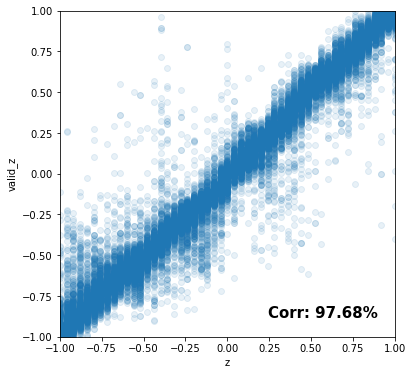

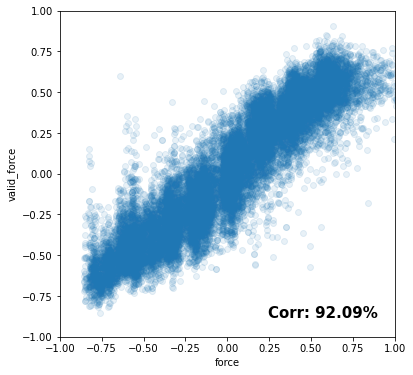

In [173]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1
output_dir = "myLearningData/savefig"  # 저장할 폴더 이름

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['z', 'force']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(-1, 1)  # x축 범위 설정
    plt.ylim(-1, 1)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()
